In [17]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [18]:
df_news = pd.read_csv("../data/news_apple_2022.csv", index_col=0)
df_price = pd.read_csv("../data/price_apple_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:32:44  I actually lost weight this holiday season — t...
1 2022-01-01 00:52:34  January Dogs Of The Dow Need A PullbackThirty-...
2 2022-01-01 01:04:02  I switched from Android to iPhone — here's wha...
3 2022-01-01 01:36:26  365 Inspirational Quotes for 2022Inspiring, po...
4 2022-01-01 02:06:21  Is Fitbit Premium worth it? Here's the pros an...
                 date       price
0 2022-01-03 09:31:00  175.826576
1 2022-01-03 09:32:00  176.596792
2 2022-01-03 09:33:00  176.636290
3 2022-01-03 09:34:00  176.776509
4 2022-01-03 09:35:00  176.705412


In [64]:
dfs = []
for i in range(1, 6):
    df_score = pd.read_csv(f"../data/news_score_apple_2022_{i}.csv", index_col=0)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/news_score_apple_2022_all.csv")
df_score

,date,score
0,2022-01-01 00:32:44,0
1,2022-01-03 08:16:20,1
2,2022-01-03 15:35:48,-1
3,2022-01-04 05:49:27,1
4,2022-01-04 10:47:02,0
...,...,...
10530,2022-06-28 21:51:40,0
10531,2022-06-29 01:45:58,-1
10532,2022-06-29 04:46:26,-1
10533,2022-06-29 06:31:43,1


In [66]:
df_score = df_score.sort_values("date")
df_score.reset_index(drop = True, inplace = True)
df_score

,date,score
0,2022-01-01 00:32:44,0
1,2022-01-01 00:52:34,1
2,2022-01-01 01:04:02,0
3,2022-01-01 01:36:26,0
4,2022-01-01 07:26:01,1
...,...,...
10530,2022-12-29 20:16:15,0
10531,2022-12-30 07:02:20,1
10532,2022-12-30 16:50:34,-1
10533,2022-12-31 02:03:24,0


In [74]:
df_score["score"].value_counts()

 1    6386
 0    2284
-1    1860
 5       5
Name: score, dtype: int64

In [48]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [49]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [50]:
df_news.shape

(43832, 2)

In [51]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [52]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [53]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
113,2022-01-03 09:39:53,Apple's wearable gadget business grew like gan...,178.068103,1.0,0.001497,-0.002163,0.004714,0.003161
121,2022-01-03 10:04:28,My 3 Favorite ETFs to Own in 2022These three E...,178.808695,1.0,0.000552,0.000828,-0.000607,-0.002596
122,2022-01-03 10:16:38,Wacom's One 13-inch drawing tablet upgrades yo...,178.788946,1.0,-0.002872,-0.001105,0.000387,-0.001491
123,2022-01-03 10:22:45,Water Ways Technologies Strengthens its Board ...,178.349528,1.0,0.001966,0.001301,0.002575,0.002962
132,2022-01-03 11:13:34,Roblox And The Sentiment MonsterThe price acti...,178.611204,0.0,0.000332,0.002267,0.004036,0.002101
...,...,...,...,...,...,...,...,...
43041,2022-12-22 10:37:25,SPY And QQQ: Sleighin' Or Getting Slayed?Lofty...,130.544618,1.0,0.001331,0.001978,0.003309,0.001331
43361,2022-12-27 11:18:45,Charter's (CHTR) Slow Internet Customer Growth...,128.74041,-1.0,0.000386,0.002240,0.004017,0.005562
43481,2022-12-28 11:37:34,Netflix's (NFLX) Glass Onion Hits the Right Ch...,126.393527,1.0,0.000551,-0.001967,-0.003226,-0.000787
43500,2022-12-28 13:18:25,"Stocks making the biggest moves midday: Tesla,...",127.11947,0.0,-0.003520,-0.003520,-0.005398,-0.005632


In [54]:
result_df = result_df.dropna()

In [55]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_3932/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,3390,3390,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000
unique,3388,3364,2679.000000,NaN,NaN,NaN,NaN,NaN
top,2022-11-14 11:02:40,AppsFlyer Named “Best Overall Mobile Marketing...,146.168556,NaN,NaN,NaN,NaN,NaN
freq,2,2,7.000000,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 09:39:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-29 12:08:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.493215,0.000025,0.000046,0.000176,-0.000020
std,NaN,NaN,NaN,0.756470,0.002057,0.002904,0.004802,0.006457
min,NaN,NaN,NaN,-1.000000,-0.013666,-0.026658,-0.022939,-0.030785
25%,NaN,NaN,NaN,0.000000,-0.000999,-0.001497,-0.002510,-0.003507


In [56]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [57]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [58]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,-0.004125,0.021159,-0.000244,-0.007063
return_in5,-0.004125,1.000000,0.721073,0.450454,0.358402
return_in10,0.021159,0.721073,1.000000,0.607948,0.452450
return_in20,-0.000244,0.450454,0.607948,1.000000,0.724029
return_in60,-0.007063,0.358402,0.452450,0.724029,1.000000


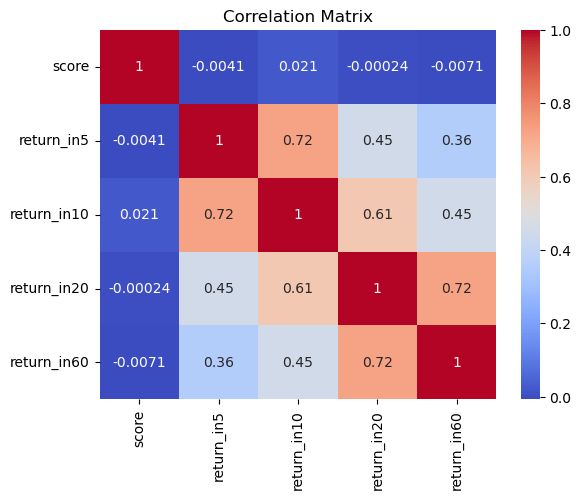

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

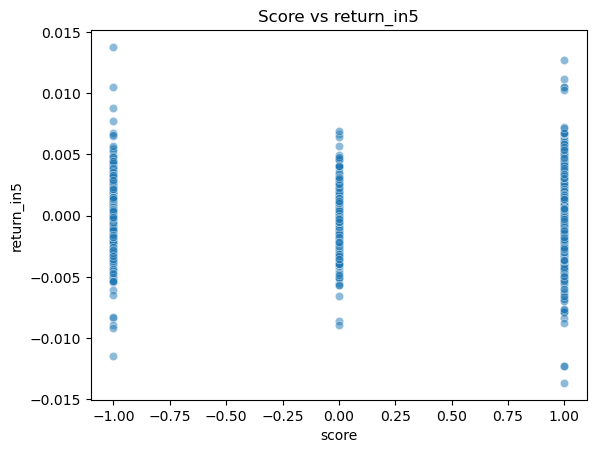

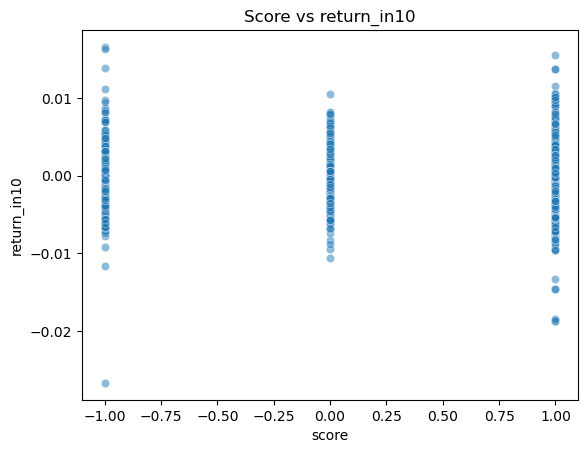

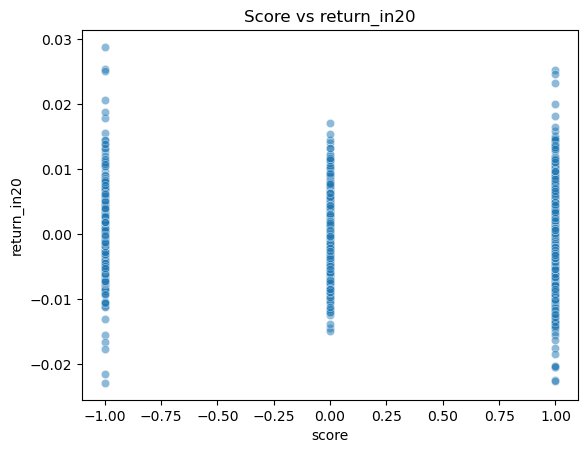

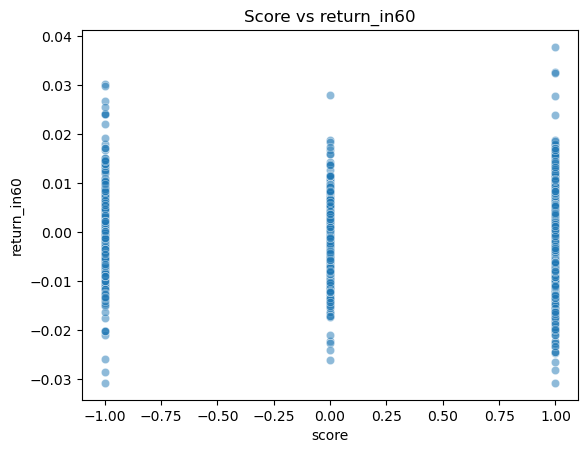

In [60]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=result_df, alpha=0.5)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [61]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(3390, 4)

In [62]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [63]:
lr.coef_

array([[-1.12177185e-05],
       [ 8.12187207e-05],
       [-1.54684760e-06],
       [-6.02928282e-05]])

In [85]:
return_names = ["return_in5", "return_in10","return_in20","return_in60"]
for name in return_names:
    for j in [-1, 0, 1]:
        print(f"When score is {j}, the mean {name} is {result_df[result_df['score'] == j][name].mean()*10000}")
    

When score is -1, the mean return_in5 is 0.8287578814938451
When score is 0, the mean return_in5 is -0.4095919562293031
When score is 1, the mean return_in5 is 0.29506721516113177
When score is -1, the mean return_in10 is 0.188577007721697
When score is 0, the mean return_in10 is -1.5728211116655149
When score is 1, the mean return_in10 is 1.1060408502791108
When score is -1, the mean return_in20 is 3.2378324943246195
When score is 0, the mean return_in20 is -0.781865713149689
When score is 1, the mean return_in20 is 2.1070165908720693
When score is -1, the mean return_in60 is 3.963588437631858
When score is 0, the mean return_in60 is -5.589306038013893
When score is 1, the mean return_in60 is 0.29936157667093816
